In [ ]:
# installing extra packages
!pip install distance
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=35777b658f461bbae877d16971195257831c382c60828c5f6d918713496ca31c
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
import os
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/MyDrive/Quora-question-pair-similarity-master')

# Exploratory Data Analysis

In [ ]:
# Read the CSV file into a Pandas DataFrame
data = pd.read_csv('data/train.csv')

# Print the number of data points in the DataFrame
print(f'The number of datapoints is {data.shape}')

# Display the first 5 rows of the DataFrame
data.head(5)


The number of datapoints is (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


We have the following columns

* id: A unique id for the question pair
* qid1: id of the first question.
* qid2: id of the second question
* question1: the first question
* question2: second question
* is_duplicate: Whether both are duplicate or not.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Checking for null values

In [ ]:
data[data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


We have 2 missing values corresponding to question2 and 1 corresponding to question 1. We will drop those 3 rows

In [ ]:
data = data.dropna()
data.shape

(404287, 6)

## Check for duplicate entries

In [ ]:
data[data.drop(columns=['id']).duplicated()]

,id,qid1,qid2,question1,question2,is_duplicate


We don't have any duplicate rows present

## Analyzing distribution of target variable

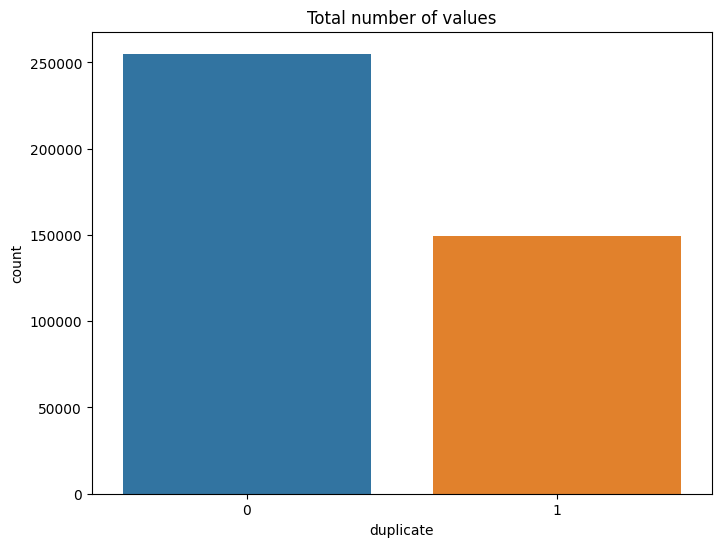

Total number of question pairs is 404287
Question pairs that are similar is 149263 which is 37 % of total
Question pairs that are not similar is 255024 which is 63 % of total


In [ ]:
# Create a bar plot to show the distribution of duplicate and non-duplicate question pairs
plt.figure(figsize=(8,6))
ct = data['is_duplicate'].value_counts()
sns.barplot(x=ct.index, y=ct.values)
plt.title('Total number of values')
plt.xlabel('Duplicate')
plt.ylabel('Count')
plt.show()

# Print the total number of question pairs in the dataset
print('Total number of question pairs is {}'.format(len(data.id.values)))

# Print the number and percentage of question pairs that are similar
print('Question pairs that are similar is {} which is {}% of total'.format(ct[1], round((ct[1]/(ct[1]+ct[0])*100))))

# Print the number and percentage of question pairs that are not similar
print('Question pairs that are not similar is {} which is {}% of total'.format(ct[0], round((ct[0]/(ct[1]+ct[0])*100))))


## Number of uniques questions and repeated questions

In [ ]:
# Create a Series combining qid2 and qid1 columns to obtain all question IDs
qids = pd.Series(data.qid2.tolist() + data.qid1.tolist())

# Calculate the total number of unique questions
uniq = len(np.unique(qids))
print('Total number of unique questions is {}'.format(uniq))

# Count the number of occurrences for each question ID
cnt = qids.value_counts()

# Determine the number of questions that are repeated more than once
more1 = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {} which is {}%'.format(more1, (more1 / (len(cnt)) * 100)))

# Find the maximum number of times a question occurs
print('The maximum number of times a question occurred is {}'.format(max(cnt)))


Total number of unique questions is 537929
Number of questions that repeated more than 1 time is 111778 which is 20.779322178205675%
The maximum number of times a question occured is 157


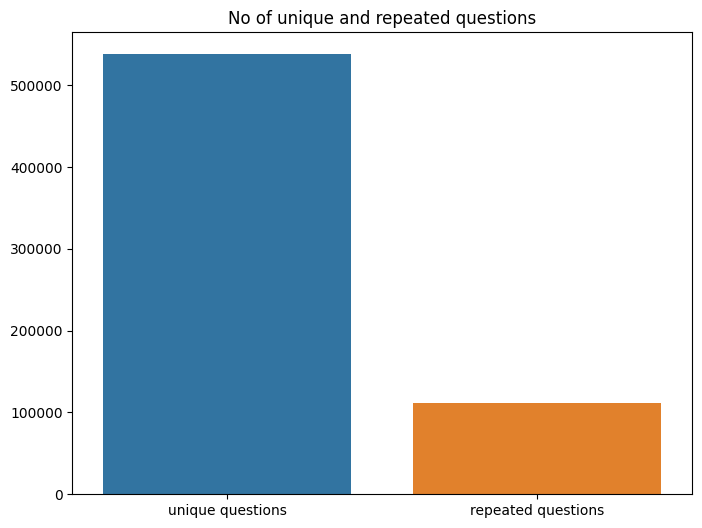

In [ ]:
# Create a bar plot to show the number of unique and repeated questions
plt.figure(figsize=(8, 6))
x = ['Unique questions', 'Repeated questions']
y = [uniq, more1]
sns.barplot(x=x, y=y)
plt.title('Number of Unique and Repeated Questions')
plt.show()


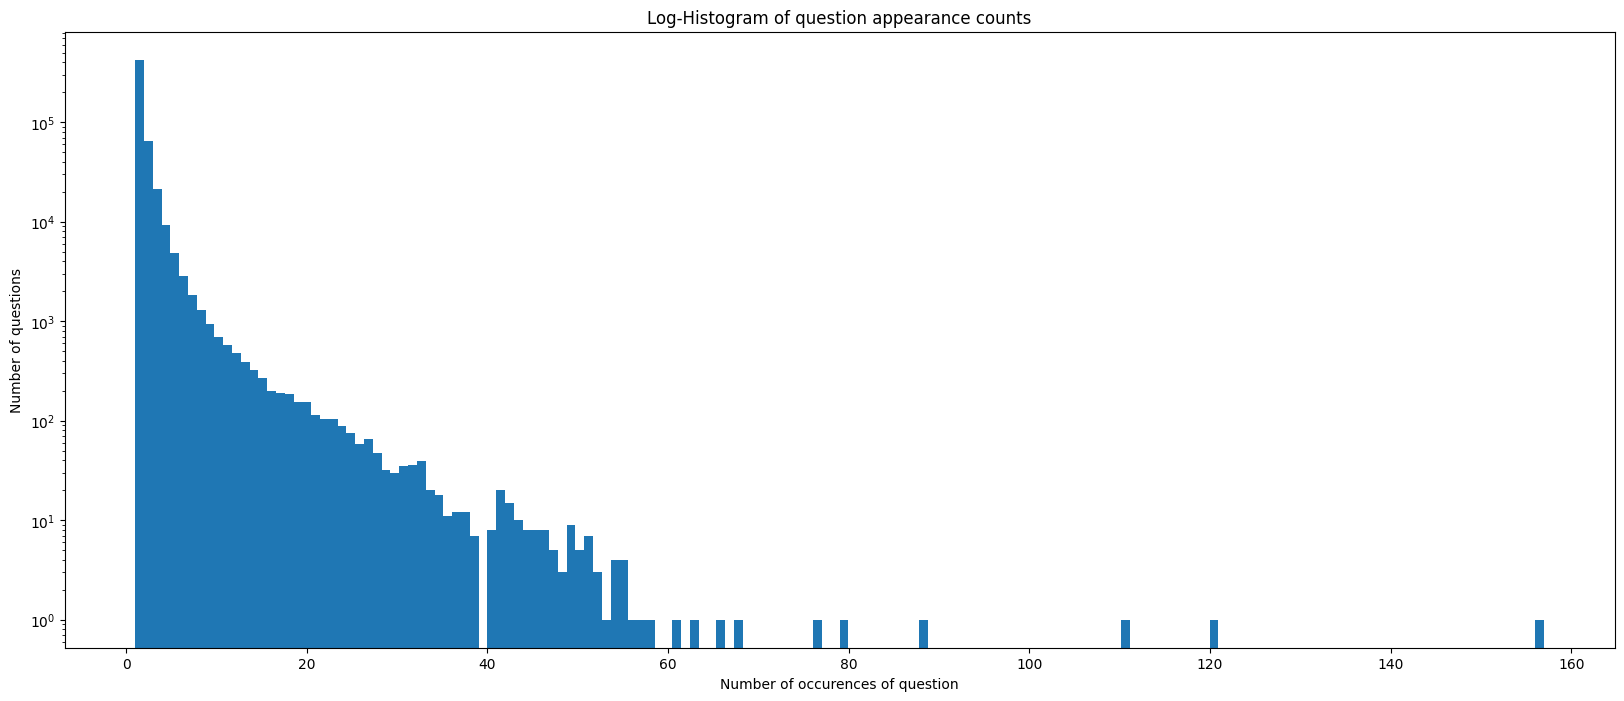

In [ ]:
# Create a figure with a larger size
plt.figure(figsize=(20, 8))

# Plot a histogram of question appearance counts
plt.hist(qids.value_counts(), bins=160)

# Set the y-axis scale to logarithmic
plt.yscale('log')

# Set the title and labels for the plot
plt.title('Log-Histogram of Question Appearance Counts')
plt.xlabel('Number of Occurrences of Question')
plt.ylabel('Number of Questions')

# Display the plot
plt.show()


# Basic Feature Engineering(Before cleaning the data)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's      #ie, number of times question1 occur
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)     
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
# Check if the file 'data_with_out_preprocess.csv' exists
if os.path.isfile('data_with_out_preprocess.csv'):
    # If the file exists, read the data from it
    data = pd.read_csv("data_with_out_preprocess.csv", encoding='latin-1')
else:
    # If the file does not exist, perform preprocessing and calculate additional features
    
    # Define a function to calculate the number of common words between two questions
    def common_wrd(row):
        x = set(row['question1'].lower().strip().split(" ")) 
        y = set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(x & y)

    # Define a function to calculate the total number of words in two questions
    def total(row):
        set1 = set(row['question1'].lower().strip().split(" "))
        set2 = set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2))

    # Define a function to calculate the word share (common words divided by total words)
    def word_share(row):
        x = row['word_common'] / row['word_total']
        return x

    # Perform preprocessing and feature calculation on the data
    data['freq_qid1'] = data['qid1'].apply(lambda x: cnt[x])
    data['freq_qid2'] = data['qid2'].apply(lambda x: cnt[x])
    data['q1len'] = data['question1'].apply(lambda x: len(x))
    data['q2len'] = data['question2'].apply(lambda x: len(x))
    data['q1_n_words'] = data['question1'].apply(lambda x: len(x.split(" ")))
    data['q2_n_words'] = data['question2'].apply(lambda x: len(x.split(" ")))
    data['word_common'] = data.apply(common_wrd, axis=1)
    data['word_total'] = data.apply(total, axis=1)
    data['word_share'] = data.apply(word_share, axis=1)
    data['freq_q1+q2'] = data['freq_qid1'] + data['freq_qid2']
    data['freq_q1-q2'] = abs(data['freq_qid1'] - data['freq_qid2'])
    
    # Save the processed data to the CSV file
    data.to_csv("data_with_out_preprocess.csv", index=False)


In [ ]:
data = pd.read_csv('data/data_with_out_preprocess.csv')
data.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,2,51,88,8,13,4.0,20.0,0.200000,6,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


## Analysis on extracted features

In [ ]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


In [ ]:
data[data['q1_n_words']== 1].head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
3306,3306,6553,6554,.,Why is Cornell's endowment the lowest in the I...,0,1,1,1,56,1,10,0.0,10.0,0.0,2,0
13016,13016,25026,25027,?,Why should one not work at Google?,0,2,2,1,34,1,7,0.0,8.0,0.0,4,0
17682,17682,33561,33562,deleted,Which website will be suitable for downloading...,0,7,1,7,67,1,10,0.0,11.0,0.0,8,6


We can see certain questions with single word.Anyway we will keep it and proceed

### Analysing word share

<ipython-input-18-bd0081dbd6ce>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 1]['word_share'],color='red',label='similar')
<ipython-input-18-bd0081dbd6ce>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 0]['word_share'],color='blue',

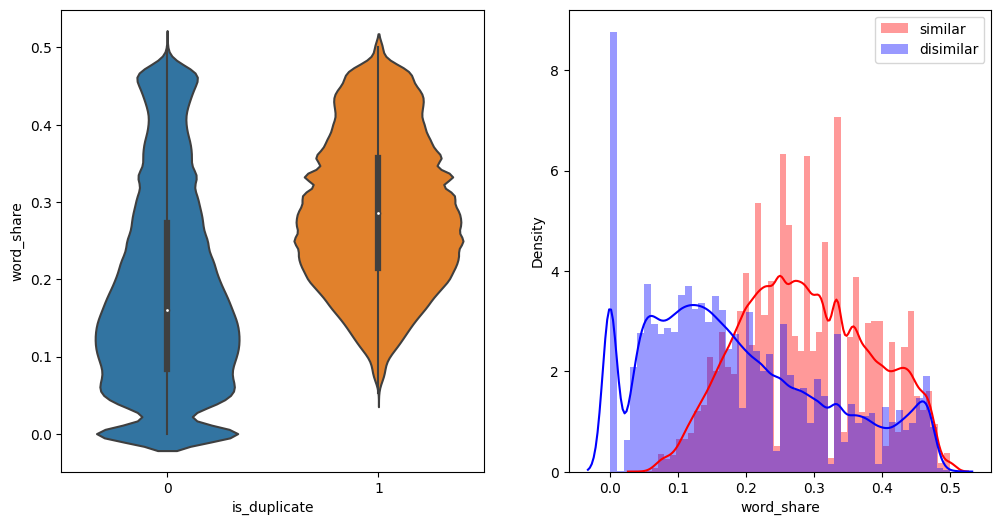

In [ ]:
# Create a figure with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Create the first subplot (violin plot)
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_share', data=data)

# Create the second subplot (distribution plots)
plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate'] == 1]['word_share'], color='red', label='Similar')
sns.distplot(data[data['is_duplicate'] == 0]['word_share'], color='blue', label='Dissimilar')

# Add a legend to the second subplot
plt.legend()

# Display the plot
plt.show()


We can see that as the word share increases there is a higher chance the questions are similar. From the histogram we can see that word share has some information differentiating similar and dissimilar classes.

### Analyzing word_common

<ipython-input-19-77a712b2f549>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 1]['word_common'],color='red',label='similar')
<ipython-input-19-77a712b2f549>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data['is_duplicate'] == 0]['word_common'],color='blue

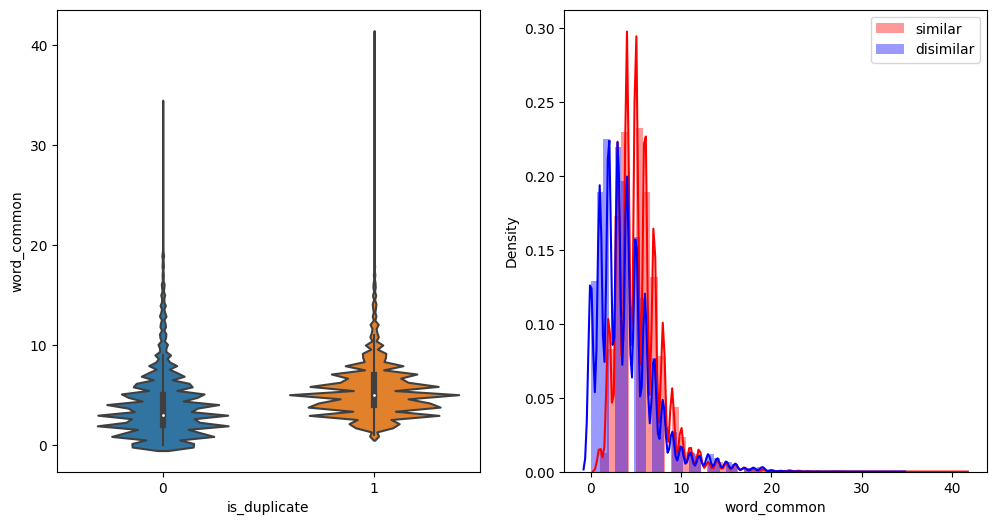

In [ ]:
# Create a figure with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Create the first subplot (violin plot)
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_common', data=data)

# Create the second subplot (distribution plots)
plt.subplot(1, 2, 2)
sns.distplot(data[data['is_duplicate'] == 1]['word_common'], color='red', label='Similar')
sns.distplot(data[data['is_duplicate'] == 0]['word_common'], color='blue', label='Dissimilar')

# Add a legend to the second subplot
plt.legend()

# Display the plot
plt.show()


We can see that common_words doesnot have enough information sepearting classes.The hist plots of word_common of duplicate and non-duplicate questions are overlapping. Not much information can be retrived as most of pdf's is overlapping. 

### Analysis on frequency of questions

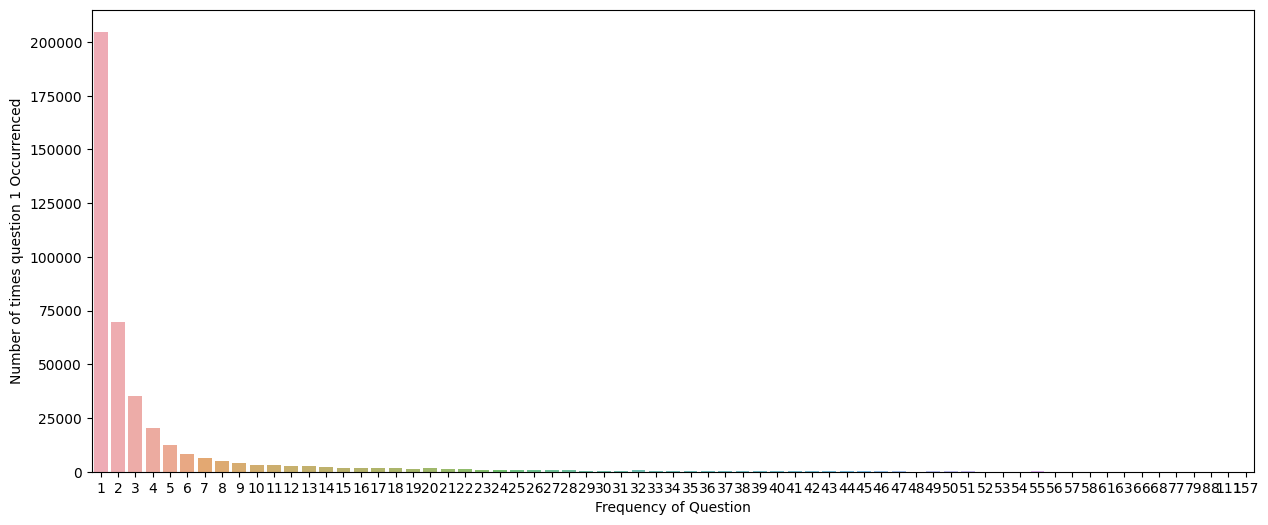

In [ ]:
# Create a figure with a size of 15x6 inches
plt.figure(figsize=(15, 6))

# Calculate the frequency counts of Question 1
my_count = data['freq_qid1'].value_counts()

# Create a bar plot
sns.barplot(x=my_count.index, y=my_count.values, alpha=0.8)

# Set the y-axis label and x-axis label
plt.ylabel('Number of times Question 1 Occurred', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)

# Display the plot
plt.show()


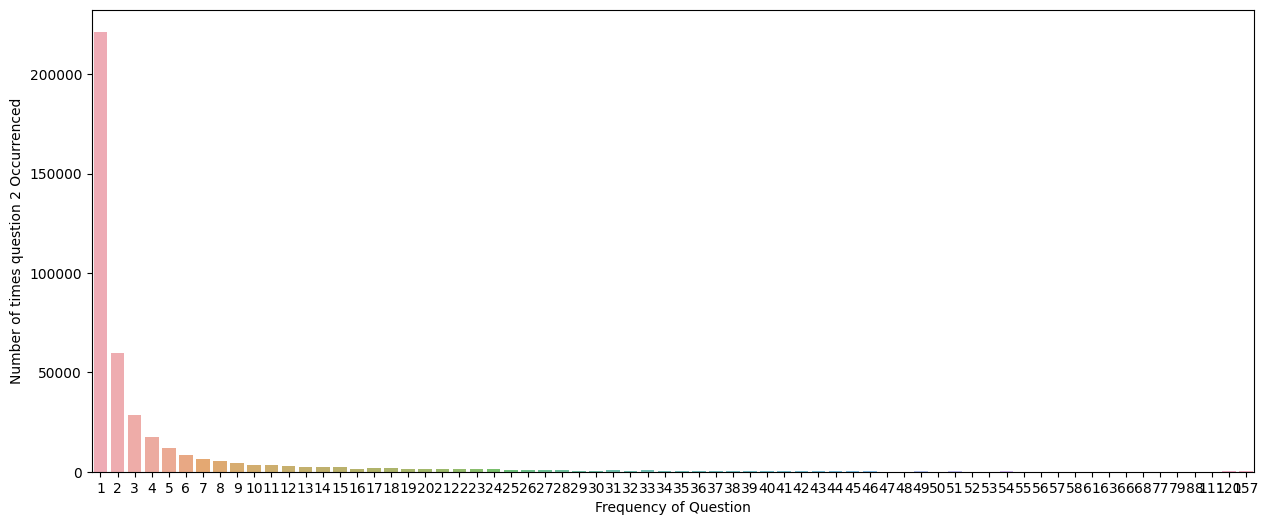

In [ ]:
# Create a figure with a size of 15x6 inches
plt.figure(figsize=(15, 6))

# Calculate the frequency counts of Question 2
my_count = data['freq_qid2'].value_counts()

# Create a bar plot
sns.barplot(x=my_count.index, y=my_count.values, alpha=0.8)

# Set the y-axis label and x-axis label
plt.ylabel('Number of times Question 2 Occurred', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)

# Display the plot
plt.show()
